# oloeriu bogdan: Advanced Lane Finding

do the necessery imports for the project

In [23]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import glob

#this is my Camera class. 


In [2]:
class Camera():

    #it creates an calibrated camera object
    def __init__(self):
        self.ret = None
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        self.imageSize = None

        #print ("hello from init function")

        # Read in a calibration image
        images  = glob.glob('./camera_cal/calibration*.jpg')
        #print("images ok")
        #plt.imshow(img)
        #plt.show()

        # Arrays to store object points and image points from all the images
        objpoints = [] #3D points in real world space
        imgpoints = [] #2d points in image plane

        # Prepare oject points, like (0,0,0), (1,0,0), (2,0,0) ...., (7,5,0)
        objp = np.zeros((6*9, 3), np.float32)
        objp[:,:2]  = np.mgrid[0:9, 0:6].T.reshape(-1,2) #x, y coordinates

        for fname in images:
            # read in each image

            img = mpimg.imread(fname)

            # Convert image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            #set the size
            if self.imageSize is None:
                self.imageSize = gray.shape[::-1]

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            # If corners are found, add object points, image points
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)

                # draw and sisplay the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                #plt.imshow(img)
                #plt.show()

                # calibrate camera for this image
                #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
                #undistorted = cv2.undistort(img, mtx, dist, None, mtx)
                #plt.imshow(undistorted)
                #plt.show()
            #else:
                #print ("Corners not found", fname)

        #calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(objpoints, imgpoints, self.imageSize, None, None)

    #it uses cv2 to undistor camera
    def undistort(self, img):
        undistorted = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undistorted

create a calibrated camera object and undistort an immage

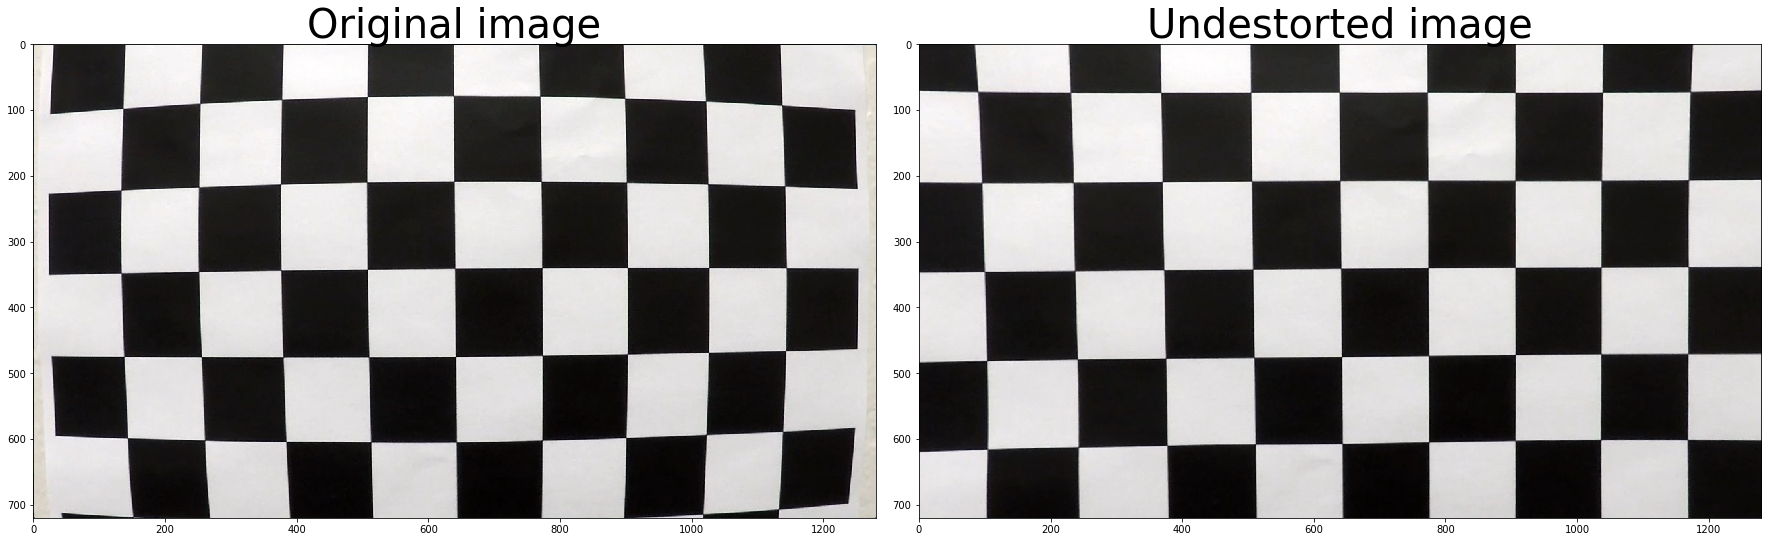

In [3]:

img = mpimg.imread('./camera_cal/calibration1.jpg')

my_camera = Camera()
undestorted_test = my_camera.undistort(img)
#plt.imshow(undestorted_test)
#plt.imshow(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


ax1.imshow(img)
ax1.set_title('Original image', fontsize=40)

ax2.imshow(undestorted_test)
ax2.set_title('Undestorted image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [4]:


# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #gray_image = gray_image = cv2.cvtColor(combined_binary, cv2.COLOR_BGR2GRAY)
    return combined_binary
    


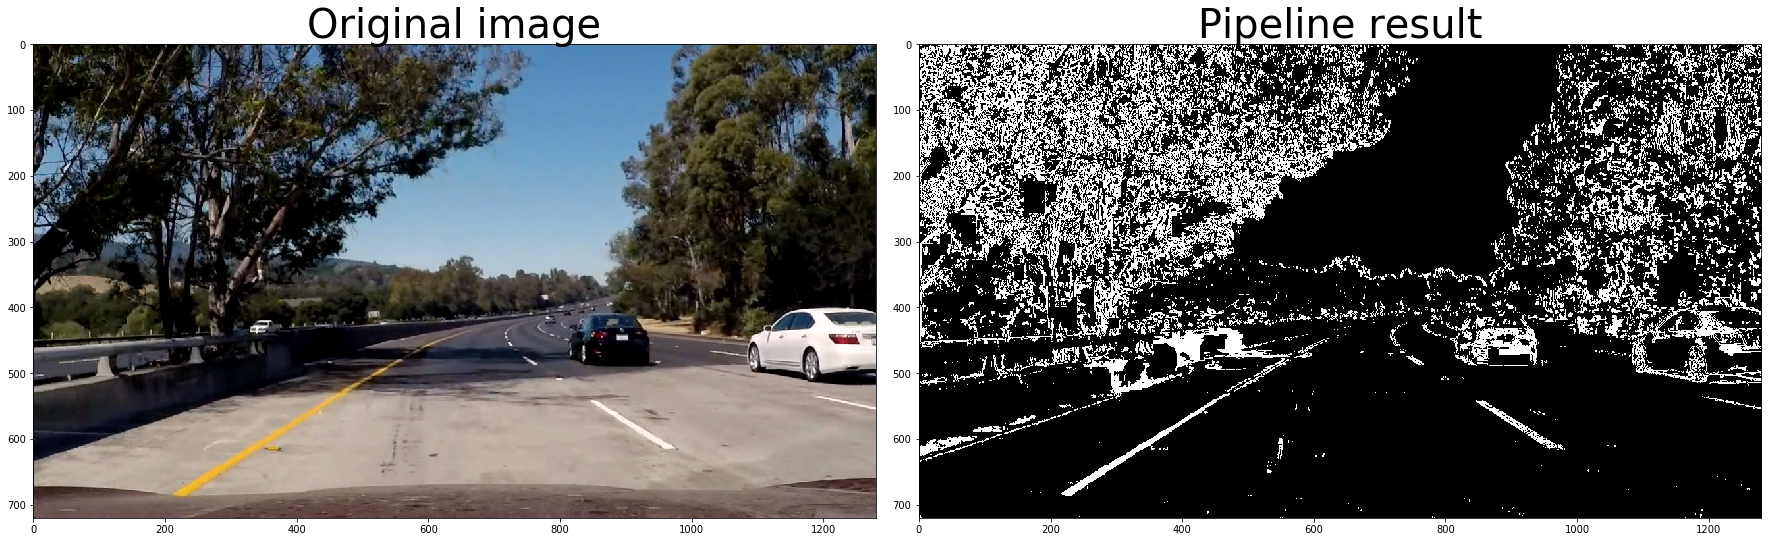

In [5]:
image = mpimg.imread('./camera_cal/color-shadow-example.jpg')
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [6]:
def get_points(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [(int(img_size[0] / 6) - 10), img_size[1]],
        [int(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    return src, dst

In [7]:
#to colect image meta data for the write up report list the points
def list_points():
    image = mpimg.imread('./output_images/worpTest.png')
    
    img_size = (image.shape[1], image.shape[0])
    src, dst = get_points(image)
    
    print (img_size[0],img_size[1])
    print("src = ", src)
    print("dst = ", dst)
    
list_points()

1280 720
src =  [[  585.   460.]
 [  203.   720.]
 [ 1126.   720.]
 [  695.   460.]]
dst =  [[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


In [8]:

def warp(img):
    # Use my camera to remove distortion
    undist = my_camera.undistort(img)
    
    img_size = (img.shape[1], img.shape[0])
    
    src, dst = get_points(img)
        
    #Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def get_Minv(img):
    src, dst = get_points(img)
    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    return Minv


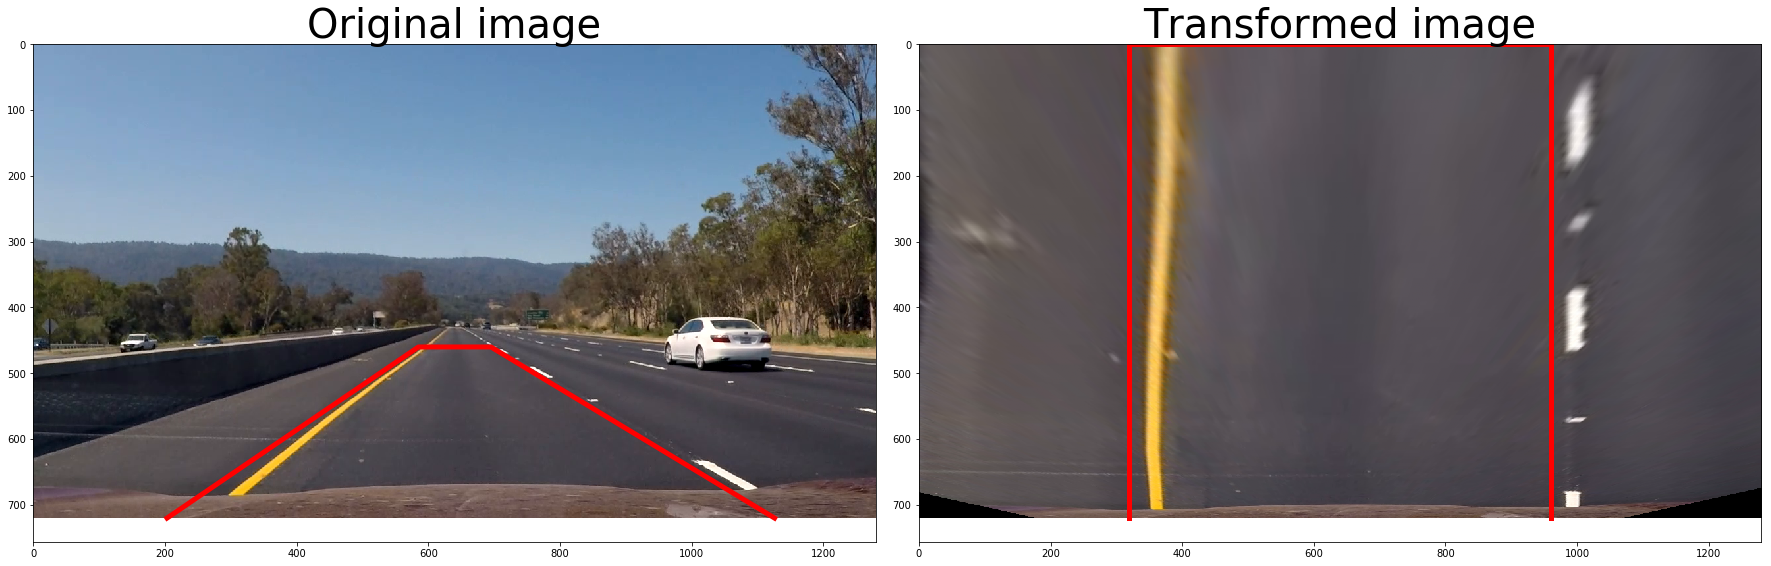

In [9]:
#collect data for write up report: transforemed image with lines
image = mpimg.imread('./output_images/worpTest.png')
warped = warp(image)

src, dst = get_points(img)
src_x = src[1][0], src[0][0] ,src[3][0] , src[2][0]
src_y = src[1][1], src[0][1] ,src[3][1] , src[2][1]
dest_x = dst[1][0], dst[0][0] ,dst[3][0] , dst[2][0] 
dest_y = dst[1][1], dst[0][1] ,dst[3][1] , dst[2][1]

# Plot perspective result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original image', fontsize=40)
ax1.plot(src_x, src_y, 'r', linewidth=5.0)

ax2.imshow(warped)
ax2.set_title('Transformed image', fontsize=40)
ax2.plot(dest_x, dest_y, 'r', linewidth=5.0)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

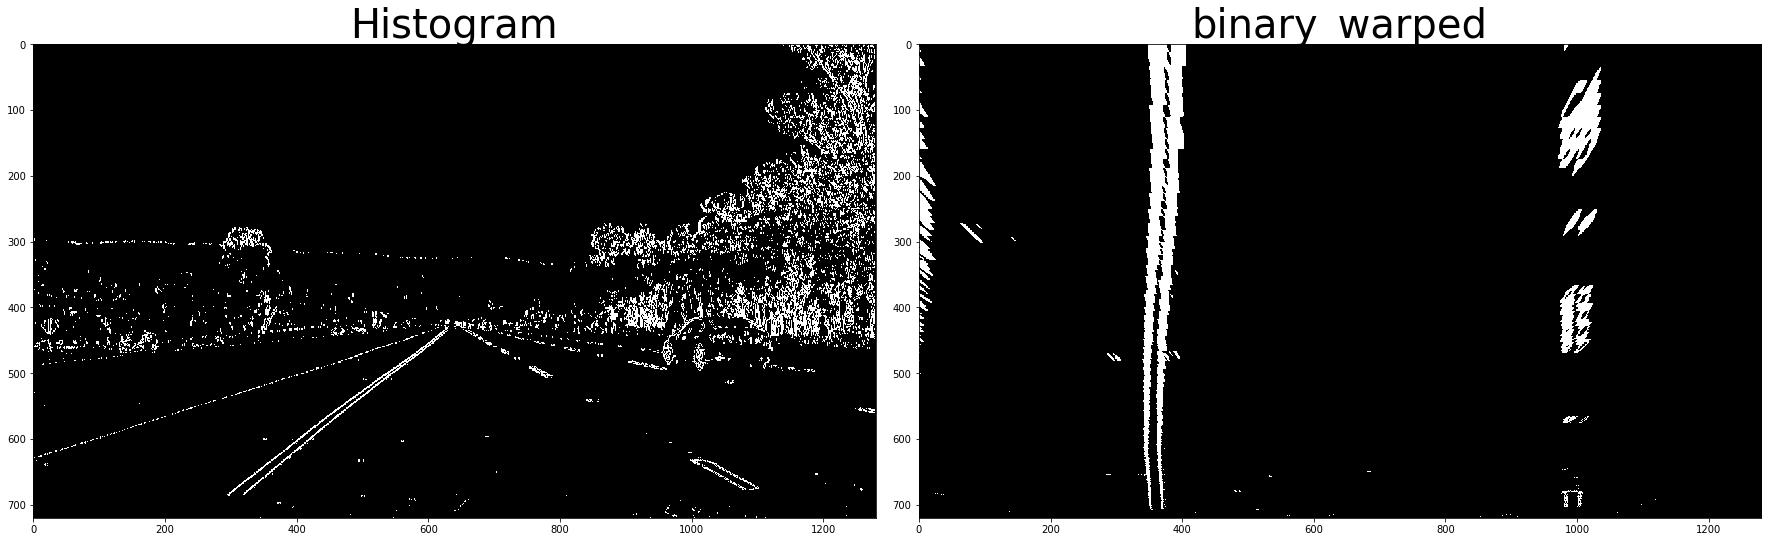

In [10]:
image = mpimg.imread('./output_images/worpTest.png')
image_filtered = pipeline(image)
binary_warped = warp(image_filtered)

# Plot perspective result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_filtered, cmap='gray')
ax1.set_title('Histogram', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('binary_warped', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [17]:
class Lines():
    
    #it creates the class object that has everithing that it needs to locates the lane lines
    def __init__(self):
        self.normal_find = None
        self.left_fit = None
        self.right_fit = None
        self.left_fitx = None
        self.right_fitx = None
        self.original = None
        self.binary_warped = None
                
        #usfull immages and objects to show
        self.history_warp_binary = None
        self.out_img = None
        self.nonzero = None
        self.left_lane_inds = None
        self.right_lane_inds = None
        self.margin = None
        self.ploty = None
        self.nonzerox = None
        self.nonzeroy = None
        self.final_image = None
        
    
    def find_lane_lines(self, image):
        self.original = image
        image_filtered = pipeline(image)
        binary_warped = warp(image_filtered)
        
        
        self.history_warp_binary = binary_warped
        start_section = int(binary_warped.shape[0]/2)
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        #histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        histogram = np.sum(binary_warped[start_section:,:], axis=0)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        self.left_lane_inds = left_lane_inds
        self.right_lane_inds = right_lane_inds

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        self.leftx = leftx
        self.lefty = lefty
        self.rightx = rightx
        self.righty = righty
        
        #self.out_img
        self.out_img = out_img
        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
        
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
                
        #usfull immages and objects to show
        self.left_lane_inds = left_lane_inds
        self.right_lane_inds = right_lane_inds
        self.normal_find = True
        
    def show_lines(self):
        out_img = self.out_img
        nonzerox = self.nonzerox
        nonzeroy = self.nonzeroy
        left_lane_inds = self.left_lane_inds 
        right_lane_inds = self.right_lane_inds 
        
        left_fit, right_fit = self.left_fit, self.right_fit
        
        #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    def fast_find(self, image):
        if self.normal_find is None:
            self.find_lane_lines(image)
            self.fast_find(image)
            return
            
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        self.original = image
        image_filtered = pipeline(image)
        binary_warped = warp(image_filtered)
        left_fit, right_fit = self.left_fit, self.right_fit
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # asign object utility values
        self.nonzeroy = nonzeroy
        self.nonzerox = nonzeroy
        self.left_lane_inds = left_lane_inds
        self.right_lane_inds = right_lane_inds
        self.left_fit = left_fit
        self.right_fit = right_fit
        self.left_fitx = left_fitx
        self.right_fitx = right_fitx
        self.margin = margin
        self.ploty = ploty
        self.binary_warped = binary_warped
        
        
    def show_history_warp_binary(self):
        plt.imshow(self.history_warp_binary)
        plt.show()
        
    
        
    def shwow_fast_lines(self):
        nonzeroy = self.nonzeroy
        nonzerox = self.nonzerox
        left_lane_inds = self.left_lane_inds
        right_lane_inds = self.right_lane_inds
        right_fit = self.right_fit
        right_fit = self.right_fit
        left_fitx = self.left_fitx
        right_fitx = self.right_fitx
        margin = self.margin
        ploty = self.ploty
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    def find_curvature(self, show_plot=False):
        
        # Generate some fake data to represent lane-line pixels
        ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
        quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
        # For each y position generate random x position within +/-50 pix
        # of the line base position in each case (x=200 for left, and x=900 for right)
        leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                      for y in ploty])
        rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                        for y in ploty])

        leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
        rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


        # Fit a second order polynomial to pixel positions in each fake lane line
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Plot up the fake data
        if show_plot is True:
            mark_size = 3
            plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
            plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
            plt.xlim(0, 1280)
            plt.ylim(0, 720)
            plt.plot(left_fitx, ploty, color='green', linewidth=3)
            plt.plot(right_fitx, ploty, color='green', linewidth=3)
            plt.gca().invert_yaxis() # to visualize as we do the images
            plt.show()
        
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        #print(left_curverad, right_curverad)
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        self.left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        self.right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        #print(left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m
        
    def get_curvature(self):
        return self.left_curverad, self.right_curverad
        
    def draw_lines(self, show_plot=False):
        # Create an image to draw the lines on
        warped = self.binary_warped
        image = self.original
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        img_size = (image.shape[1], image.shape[0])
        Minv = get_Minv(image)
        newwarp = cv2.warpPerspective(color_warp, Minv, img_size, flags=cv2.INTER_LINEAR) 
        
        #make the same type
        newwarp = np.array(newwarp).astype('float')
        image = np.array(image).astype('float')
                
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        self.final_image = result
        if show_plot is True:
            plt.imshow(self.final_image)
            plt.show()
            
    def get_final_image(self):
        return self.final_image

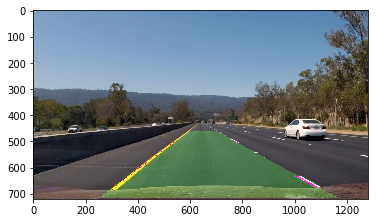

In [80]:

lines = Lines()
image = mpimg.imread('./output_images/worpTest.png')
#lines.find_lane_lines(image)
#lines.show_history_warp_binary()
#lines.show_lines()

lines.fast_find(image)
#lines.shwow_fast_lines()
lines.find_curvature(show_plot=False)

lines.draw_lines(show_plot=False)
final_image = lines.get_final_image()

font = cv2.FONT_HERSHEY_SIMPLEX

#plt.axis('off')
plt.imshow(final_image)
plt.show()

#cv2.putText(text_image,'Hello World!',(100,500), font, 1,(255,255,255),5)
#http://stackoverflow.com/questions/14869321/is-there-a-way-to-convert-pyplot-imshow-object-to-numpy-array

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
#reset the lines object
lines = Lines()
def process_image(image):
    lines.fast_find(image)
    #lines.shwow_fast_lines()
    lines.find_curvature(show_plot=False)

    lines.draw_lines(show_plot=False)
    final_image = lines.get_final_image()
    return final_image

In [15]:


white_output = './output_images/project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_images/project_result.mp4
[MoviePy] Writing video ./output_images/project_result.mp4


100%|█████████▉| 1260/1261 [03:07<00:00,  6.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_result.mp4 

CPU times: user 6min 49s, sys: 4.88 s, total: 6min 54s
Wall time: 3min 8s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))